In [16]:
#Importing packages
%matplotlib inline
import copy
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture
import random
import pandas as pd


In [17]:
#Setting random seeds
seed = 25
np.random.seed(seed)
random.seed(15)

In [18]:
#Loading PK data
pk_a_1 = np.load("pk_a_1.npy")
pk_a_25 = np.load("pk_a_25.npy")
ain = np.abs(np.reshape(np.array(pk_a_25),(-1,10)))

In [19]:
#Preprocessing
tags = ["Generic-Tag","Tag-6","Tag-8","Tag-9","Tag-12","Tag-17"]
biotin = ["6-Biotin","8-Biotin","9-Biotin","12-Biotin","17-Biotin"]
ant = ['0.25 ug']
form = ['1','2','3','4','5','6']
pl = []
pl2 = []
for i in range(len(ain)):
    a = i//180 #1 for pk_a_1 and 0 for pk_a_25
    g = i + 1 - (180*a)
    f = g%30 # if the last it is 0
    F = g//30 - (0 ** f)
    b = g%6 # if the last it is 0
    B = (g - (F*30))//6  - (0**b)
    T = g%6
    pl.append(tags[T]+"/"+biotin[B]+ " antigen ["+ant[a]+"] format "+form[F])
    pl2.append([T,B,a,F])

#pk_a shape is 180 by 10 (anal. vals), first dimension is the six tags repeated
#for each of the five biotin-IDs which in turn
#is repeated for each six formats

In [20]:
#Defining helper functions

def thresh_h(val,ax,i1,second):
    if val == 0:
        ax[second+(i1//2)*2,i1%2].plot([200,200],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([750,750],[-0.1,.1],c='grey')
    if val in (1,2):
        ax[second+(i1//2)*2,i1%2].plot([65000,65000],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([100000,100000],[-0.1,.1],c='grey')
    if val in (3,4):
        ax[second+(i1//2)*2,i1%2].plot([500,500],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([1000,1000],[-0.1,.1],c='grey')
    if val in (5,6):
        ax[second+(i1//2)*2,i1%2].plot([3,3],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([5,5],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([10,10],[-0.1,.1],c='grey')
    if val in (7,8,9):
        ax[second+(i1//2)*2,i1%2].plot([30,30],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([20,20],[-0.1,.1],c='grey')
        ax[second+(i1//2)*2,i1%2].plot([10,10],[-0.1,.1],c='grey')


def pk_bd_s(inp,nu):
    inp = np.abs(inp)
    if nu in [0,7,8,9]:
        org = (min(inp[:,0]),np.argmin(inp[:,0]))
    else:
        org = (max(inp[:,0]),np.argmax(inp[:,0]))
    return(org)


def get_best_s(inp,nu):
    ind = pk_bd_s(inp,nu)
    return(ind)

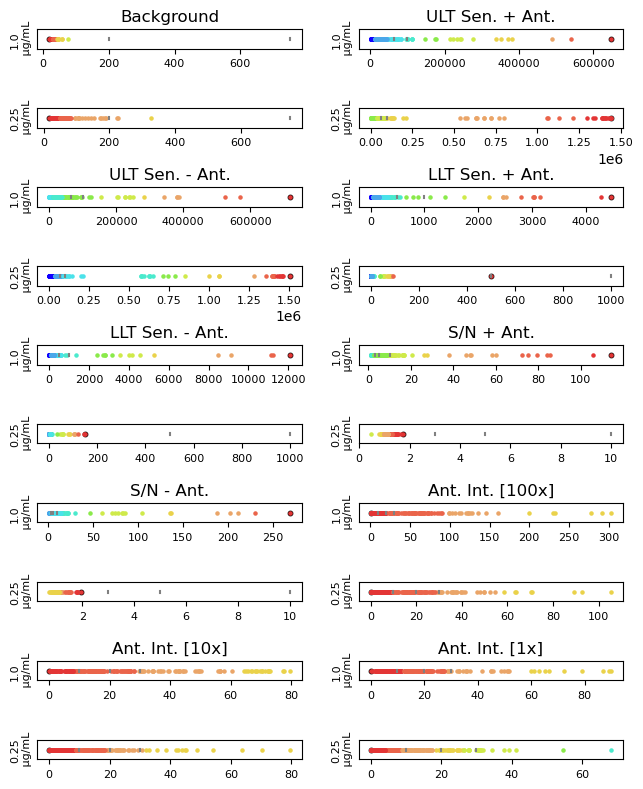

In [21]:
#Plotting and displaying results of GMMs
fig, ax = plt.subplots(10, 2, figsize=(6.5, 8))


def sm_gmm(inp,metric="aic"):
    metric = metric
    bil = []
    title_l = ['Background','ULT Sen. + Ant.','ULT Sen. - Ant.','LLT Sen. + Ant.',
               'LLT Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
               "Ant. Int. [10x]","Ant. Int. [1x]"]
    for i1 in np.arange(10):
        gmm_10.append([])
        gmm_10[-1].append(title_l[i1])
        avv = np.array([inp[:,i1],np.zeros(len(inp))]).transpose()
        avv2 = avv
        lowest_bic = np.infty
        bic = []
        n_components_range = range(4, 11)
        cv_types = ['diag']
        for cv_type in cv_types:
            for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
                gmm = mixture.GaussianMixture(n_components=n_components,
                                            covariance_type=cv_type)
                gmm.fit(avv2)
                if metric == 'bic':
                    bic.append(gmm.bic(avv2))
                elif metric == 'aic':
                    bic.append(gmm.aic(avv2))
                elif metric == 'score':
                    bic.append(-1*gmm.score(avv2))
                gmm_10[-1].append(bic[-1])
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm
                    
        bic = np.array(bic)
        color_iter = itertools.cycle(['#614AEA', '#4A62EA', '#4AA7EA',
                                    '#4AE2EA','#4AEACD','#4AEA6A','#8AEA4A',
                                    '#CFEA4A','#EAD24A','#EAA568'])
        clf = best_gmm
        Y_ = clf.predict(avv2)
        bil.append(get_best_s(avv,i1))
        ax[second+(i1//2)*2,i1%2].scatter(get_best_s(avv,i1)[0],0,c='k',s=10)
        thresh_h(i1,ax,i1,second)
        colors = ['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"]
        colors.reverse()
        Y_v_list = []
        for i in range(max(Y_)+1):
            Y_v = [avv[v[0],0] for v in enumerate(Y_) if v[1] == i]
            Y_v_list.append(np.mean(Y_v))#appends max value by increasing Y_ labels
        colors_p = copy.deepcopy(colors)
        if i1 not in (0,7,8,9):
            Y_v_list = [-v for v in Y_v_list]
        cl = np.arange(10)
        cl = list(cl)
        Y_score = []
        for sort_val in enumerate(np.argsort(Y_v_list)):
            Y_score.append(cl[sort_val[1]])
            sc = colors_p[sort_val[0]]
            cl[sort_val[1]] = str(sc)

        Y_score.reverse()

        for index_v in enumerate(Y_):
            gmm_10_scores[index_v[0]+1].append(Y_score.index(index_v[1]))

        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                                color_iter)):
            if not np.any(Y_ == i):
                continue
            ax[second+(i1//2)*2,i1%2].scatter(avv[Y_ == i, 0], avv[Y_ == i, 1], s=5, color=cl[i])
        ax[second+(i1//2)*2,i1%2].set_ylim([-1, 1])
        ax[second+(i1//2)*2,i1%2].tick_params(axis='both', which='major', labelsize=8)
        if not second:
            ax[second+(i1//2)*2,i1%2].set_title(title_l[i1],fontsize=12)
            ax[second+(i1//2)*2,i1%2].set_ylabel('1.0\n µg/mL',fontsize=8)
        else:
            ax[second+(i1//2)*2,i1%2].set_ylabel('0.25\n µg/mL',fontsize=8)
        ax[second+(i1//2)*2,i1%2].set_yticks(())


gmm_10 = [["Analytical Metric","4 Components",
          "5 Components", "6 Components", "7 Components", "8 Components", "9 Components",
          "10 Components"]]
gmm_10_scores = [["PKA Conditions",'Background','ULOQ Sen. + Ant.','ULOQ Sen. - Ant.','LLOQ Sen. + Ant.',
                  'LLOQ Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
                  "Ant. Int. [10x]","Ant. Int. [1x]","Total"]]
for i in range(len(ain)):
    gmm_10_scores.append([pl[i]])

second = False
sm_gmm(np.abs(np.reshape(np.array(pk_a_1),(-1,10))))
c = 1
for i in gmm_10_scores[1:]:
    gmm_10_scores[c].append(sum(gmm_10_scores[c][1:]))
    c += 1

gmm_10_pk_1ug_aic = pd.DataFrame(gmm_10)
#gmm_10.to_csv("Data/PK/gmm_pk_individual_aic_1ug.csv",index=False,header=False)
gmm_10_pk_1ug_scores = pd.DataFrame(gmm_10_scores)
#gmm_10_scores.to_csv("Data/PK/gmm_pk_individual_scores_1ug.csv",index=False,header=False)


##############


gmm_10 = [["Analytical Metric","4 Components",
          "5 Components", "6 Components", "7 Components", "8 Components", "9 Components",
          "10 Components"]]
gmm_10_scores = [["PKA Conditions",'Background','ULOQ Sen. + Ant.','ULOQ Sen. - Ant.','LLOQ Sen. + Ant.',
                  'LLOQ Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
                  "Ant. Int. [10x]","Ant. Int. [1x]","Total"]]

for i in range(len(ain)):
    gmm_10_scores.append([pl[i]])

second = True
sm_gmm(np.abs(np.reshape(np.array(pk_a_25),(-1,10))))

c = 1
for i in gmm_10_scores[1:]:
    gmm_10_scores[c].append(sum(gmm_10_scores[c][1:]))
    c += 1

gmm_10_pk_25ug_aic = pd.DataFrame(gmm_10)
#gmm_10.to_csv("Data/PK/gmm_pk_individual_aic_p25ug.csv",index=False,header=False)
gmm_10_pk_25ug_scores = pd.DataFrame(gmm_10_scores)
#gmm_10_scores.to_csv("Data/PK/gmm_pk_individual_scores_p25ug.csv",index=False,header=False)

plt.subplots_adjust(hspace=.4, bottom=.6)
plt.tight_layout(h_pad=.1)
#plt.savefig("Plots/PK/pk_gmm_allug_individual.pdf",dpi=300)

In [22]:
#Displaying tabulated results

from IPython.display import display, HTML

print('AIC of GMMs fit to 1.0 µg PK data:')
display(gmm_10_pk_1ug_aic)

print('Anti-ID+Tag scores from GMMs fit to 1.0 µg PK data:')
display(HTML(gmm_10_pk_1ug_scores.to_html()))


print('AIC of GMMs fit to 0.25 µg PK data:')
display(gmm_10_pk_25ug_aic)

print('Anti-ID+Tag scores from GMMs fit to 0.25 µg PK data:')
display(HTML(gmm_10_pk_25ug_scores.to_html()))

AIC of GMMs fit to 1.0 µg PK data:


,0,1,2,3,4,5,6,7
0,Analytical Metric,4 Components,5 Components,6 Components,7 Components,8 Components,9 Components,10 Components
1,Background,-964.059005,-970.501975,-967.863954,-963.040242,-957.613736,-949.924382,-943.847319
2,ULT Sen. + Ant.,2090.694697,2095.388665,2052.032923,2060.595217,2038.62793,2044.204574,1999.553975
3,ULT Sen. - Ant.,2106.025366,2093.359064,1998.801236,2055.149446,1960.404735,1966.595383,1972.866162
4,LLT Sen. + Ant.,196.207284,194.978147,197.493856,200.779508,204.331893,211.374053,169.739195
5,LLT Sen. - Ant.,406.142577,316.076392,325.641556,326.856652,311.355945,305.100785,286.099984
6,S/N + Ant.,-957.852542,-1046.050224,-1048.632158,-1049.428197,-1044.767126,-1042.389434,-1041.597488
7,S/N - Ant.,-864.129017,-949.175802,-940.871434,-970.665161,-974.074456,-987.06127,-980.480091
8,Ant. Int. [100x],-449.080107,-439.169518,-441.788923,-431.765896,-446.219797,-437.015031,-429.02636
9,Ant. Int. [10x],-616.178194,-615.522896,-607.529826,-609.071053,-615.272636,-594.701258,-608.319697


Anti-ID+Tag scores from GMMs fit to 1.0 µg PK data:


,0,1,2,3,4,5,6,7,8,9,10,11
0,PKA Conditions,Background,ULOQ Sen. + Ant.,ULOQ Sen. - Ant.,LLOQ Sen. + Ant.,LLOQ Sen. - Ant.,S/N + Ant.,S/N - Ant.,Ant. Int. [100x],Ant. Int. [10x],Ant. Int. [1x],Total
1,Tag-6/6-Biotin antigen [0.25 ug] format 1,1,0,0,3,2,2,1,0,2,2,13
2,Tag-8/6-Biotin antigen [0.25 ug] format 1,2,0,0,2,2,2,1,1,2,3,15
3,Tag-9/6-Biotin antigen [0.25 ug] format 1,1,0,0,0,0,0,0,1,2,1,5
4,Tag-12/6-Biotin antigen [0.25 ug] format 1,2,0,0,1,1,1,1,0,2,2,10
5,Tag-17/6-Biotin antigen [0.25 ug] format 1,2,1,0,1,1,1,1,1,3,2,13
6,Generic-Tag/6-Biotin antigen [0.25 ug] format 1,3,1,2,2,1,1,1,3,1,3,18
7,Tag-6/8-Biotin antigen [0.25 ug] format 1,4,1,0,3,2,2,2,2,2,3,21
8,Tag-8/8-Biotin antigen [0.25 ug] format 1,3,0,0,3,2,2,2,2,2,3,19
9,Tag-9/8-Biotin antigen [0.25 ug] format 1,4,0,0,0,0,0,0,2,1,2,9


AIC of GMMs fit to 0.25 µg PK data:


,0,1,2,3,4,5,6,7
0,Analytical Metric,4 Components,5 Components,6 Components,7 Components,8 Components,9 Components,10 Components
1,Background,-578.097657,-570.82335,-561.140715,-553.047918,-559.631008,-541.735197,-542.531305
2,ULT Sen. + Ant.,2382.591779,2374.04486,2349.586289,2358.804733,2366.527613,2373.500749,2370.747697
3,ULT Sen. - Ant.,2325.517382,2399.215844,2322.098446,2320.095401,2327.963172,2324.06126,2292.559116
4,LLT Sen. + Ant.,-1170.052472,-1206.156646,-1198.336868,-1188.85497,-1214.632991,-1209.496841,-1214.821031
5,LLT Sen. - Ant.,-1200.066174,-1199.523767,-1211.8168,-1212.943294,-1243.160565,-1256.216863,-1249.844373
6,S/N + Ant.,-2375.322729,-2379.104196,-2375.492211,-2367.871095,-2362.360857,-2362.000611,-2351.780164
7,S/N - Ant.,-2414.495478,-2413.726702,-2406.89982,-2396.771481,-2395.705706,-2383.175298,-2376.206584
8,Ant. Int. [100x],-736.185073,-725.954747,-721.485843,-713.238559,-725.842466,-721.026813,-719.006255
9,Ant. Int. [10x],-818.706361,-810.927059,-806.706969,-811.071972,-806.509397,-809.412575,-799.714649


Anti-ID+Tag scores from GMMs fit to 0.25 µg PK data:


,0,1,2,3,4,5,6,7,8,9,10,11
0,PKA Conditions,Background,ULOQ Sen. + Ant.,ULOQ Sen. - Ant.,LLOQ Sen. + Ant.,LLOQ Sen. - Ant.,S/N + Ant.,S/N - Ant.,Ant. Int. [100x],Ant. Int. [10x],Ant. Int. [1x],Total
1,Tag-6/6-Biotin antigen [0.25 ug] format 1,3,1,1,1,0,2,0,0,3,6,17
2,Tag-8/6-Biotin antigen [0.25 ug] format 1,3,1,1,1,1,2,1,1,2,5,18
3,Tag-9/6-Biotin antigen [0.25 ug] format 1,3,0,0,1,1,1,0,3,2,2,13
4,Tag-12/6-Biotin antigen [0.25 ug] format 1,3,1,1,0,1,2,0,2,3,5,18
5,Tag-17/6-Biotin antigen [0.25 ug] format 1,3,0,0,1,1,1,0,2,2,5,15
6,Generic-Tag/6-Biotin antigen [0.25 ug] format 1,2,4,6,1,1,2,0,3,2,6,27
7,Tag-6/8-Biotin antigen [0.25 ug] format 1,3,1,1,2,0,3,0,1,3,6,20
8,Tag-8/8-Biotin antigen [0.25 ug] format 1,3,1,1,2,2,3,1,2,3,4,22
9,Tag-9/8-Biotin antigen [0.25 ug] format 1,3,0,0,0,0,1,0,2,3,4,13
